In [205]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import datetime

In [206]:

# path0 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2019 outbound\\'
# path1 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2020 outbound\\'
# # path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2021 outbound\\'
# path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\保乐力加_train\\outbound\\'
# %%time
# dfs0 = pd.DataFrame()
# for fname in os.listdir(path0):
#     if re.search(r'\.xls$', fname):
#         dfs0 = pd.concat(
#             [dfs0 ,pd.read_excel(path0 + fname)], 
#             axis = 0, 
#             ignore_index = True)

# dfs1 = pd.DataFrame()
# for fname in os.listdir(path1):
#     if re.search(r'\.xls$', fname):
#         dfs1 = pd.concat(
#             [dfs1 ,pd.read_excel(path1 + fname)], 
#             axis = 0, 
#             ignore_index = True)


# dfs2 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xls$', fname):
#         dfs2 = pd.concat(
#             [dfs2 ,pd.read_excel(path2 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# dfs2 = dfs2.dropna(axis =1 , how = 'all')
 
# # path+
# dfs = pd.DataFrame()
# for fname in os.listdir(path):
#     if re.search(r'\.xls$', fname):
#         dfs = pd.concat(
#             [dfs ,pd.read_excel(path + fname)], axis = 0, ignore_index = True)
# prc_in = pd.DataFrame(dfs)
# prc_in = prc_in.drop(['仓库城市','仓库编号','Unnamed: 7'], axis = 1)
# prc_in.columns = ['time', 'sku','name','code','quant']

# dfs3 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xlsx$', fname):
#         dfs3 = pd.concat(
#             [dfs3 ,pd.read_excel(path3 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
  
# # dfs2.head(200)

In [271]:
# df = pd.read_clipboard()
# df.to_csv('./fas_057_rh.csv', index = False, encoding='utf_8_sig')
df = pd.read_csv('./fas_057_rh.csv')
df = df.fillna(method = 'ffill')

In [272]:
def date_mutate(col):
    df[col + '_time'] = df[col].str.slice(11,-1).astype(str)
    df[col] = df[col].str.slice(0,10)
    df[col + '_2'] = [datetime.strptime(i,'%H:%M:%S.%f').strftime('%H%M%S') for i in df[col + '_time']]
    return df.head(1)

# df.columns[df.columns.str.contains(r'date|DATE')].to_numpy()
# df[df['receipt_id'].str.findall(r'(货)').apply(len) > 1]

for i in df.columns[df.columns.str.contains(r'date|DATE')].to_numpy():
    date_mutate(i)



In [285]:
first_df = df.groupby(
    'CREATION_DATE_TIME_STAMP'
    )['CREATION_DATE_TIME_STAMP_2'].min().reset_index();first_df

# df[['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2']].sort_values(by = 'CREATION_DATE_TIME_STAMP')


,CREATION_DATE_TIME_STAMP,CREATION_DATE_TIME_STAMP_2
0,2017-09-11,032456
1,2017-09-12,050737
2,2017-09-13,012211
3,2017-09-14,002402
4,2017-09-15,014709
...,...,...
888,2021-04-25,075955
889,2021-04-28,053557
890,2021-04-29,051023
891,2021-04-30,045253


In [288]:
first_df

,CREATION_DATE_TIME_STAMP,CREATION_DATE_TIME_STAMP_2,Internal_Receipt_num,warehouse,company,receipt_id,receipt_date,CLOSE_DATE,ARRIVED_DATE_TIME,total_lines,TOTAL_QTY,TOTAL_CONTAINERS,TOTAL_WEIGHT,receipt_date_time,receipt_date_2,CLOSE_DATE_time,CLOSE_DATE_2,ARRIVED_DATE_TIME_time,ARRIVED_DATE_TIME_2,CREATION_DATE_TIME_STAMP_time
0,2017-09-11,032456,12318,FAS,Solvay-SHANGHAI,ZHUANGUAN/4512966525,2017-09-11,2017-09-14,2017-09-14,2,880.0,22,22000.00,00:00:00.00,000000,13:36:41.67,133641,13:30:40.00,133040,03:24:56.00
1,2017-09-12,050737,12321,FAS,Solvay-SHANGHAI,ZHUANGUAN/4512969246,2017-09-12,2017-09-18,2017-09-18,1,744.0,19,18600.00,00:00:00.00,000000,10:16:20.23,101620,10:12:39.00,101239,05:07:37.00
2,2017-09-13,012211,12333,FAS,Solvay-SHANGHAI,205-82893856/320411889086,2017-09-13,2017-09-14,2017-09-14,1,4.0,1,100.00,00:00:00.00,000000,13:03:11.09,130311,13:02:51.00,130251,01:22:11.00
3,2017-09-14,002402,12342,FAS,Pernod,20170914 CHANGE CODE-1,2017-09-14,2017-09-14,2017-09-14,1,6000.0,9,8000.00,00:00:00.00,000000,15:24:34.92,152434,15:19:44.00,151944,00:24:02.00
4,2017-09-15,014709,12353,FAS,Solvay-SHANGHAI,4512972142/71023208,2017-09-15,2017-09-22,2017-09-22,2,501.0,13,12525.00,00:00:00.00,000000,09:47:28.21,094728,09:41:57.00,094157,01:47:09.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,2021-04-25,075955,22156,FAS,Pernod,EGLV540100041630,2021-04-25,2021-04-27,2021-04-27,3,24192.0,18,18486.72,00:00:00.00,000000,05:59:32.16,055932,05:48:50.00,054850,07:59:55.00
889,2021-04-28,053557,22162,FAS,Pernod,227-50319861 M2100737,2021-04-28,2021-04-29,2021-04-29,2,1008.0,3,1290.24,00:00:00.00,000000,07:18:11.58,071811,07:16:57.00,071657,05:35:57.00
890,2021-04-29,051023,22163,FAS,Pernod,COSU6288760580,2021-04-29,2021-05-06,2021-05-06,1,10080.0,10,12516.00,00:00:00.00,000000,02:21:41.22,022141,02:19:05.00,021905,05:10:23.00
891,2021-04-30,045253,22168,FAS,Pernod,ONEYLIVB05481700,2021-04-30,2021-05-07,2021-05-07,1,16632.0,1,17269.56,00:00:00.00,000000,08:51:48.65,085148,08:50:06.00,085006,04:52:53.00


In [286]:

first_df = first_df.merge(
    df, 
    on = ['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2'], 
    how = 'inner')

# first_df2 = df.copy().groupby('CLOSE_DATE')[
#     ['receipt_id', 'receipt_date','total_lines', 'TOTAL_QTY']
#     ].sum().reset_index()

# first_df2.columns = ['CLOSE_DATE', 'ttl_line_cnt', 'ttl_qty_sum']

# first_df = first_df.merge(first_df2, how = 'inner', on = 'CLOSE_DATE')

In [353]:

train_first = first_df.groupby(
    'CREATION_DATE_TIME_STAMP'
    ).agg({'receipt_id':['nunique'], 
    'total_lines': ['sum'], 
    'TOTAL_CONTAINERS': 'sum', 
    'TOTAL_WEIGHT':'sum',
    'TOTAL_QTY': ['sum'],
    'CREATION_DATE_TIME_STAMP_2': 'max' }).reset_index()

In [354]:
train_full = df.groupby(
    'CREATION_DATE_TIME_STAMP'
    ).agg({'receipt_id':['nunique'], 
    'total_lines': ['sum'], 
    'TOTAL_CONTAINERS': 'sum', 
    'TOTAL_WEIGHT':'sum',
    'TOTAL_QTY': ['sum'],
    'CREATION_DATE_TIME_STAMP_2': 'max' }).reset_index()

In [355]:
train_full.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']
train_first.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']


In [372]:
plt1 = (train_full.sort_values(
    by = 'CREATION_DATE_TIME_STAMP')['qty'] - train_first.sort_values(
        by = 'CREATION_DATE_TIME_STAMP')['qty'] ).reset_index()

In [373]:
plt1

,index,qty
0,0,0.0
1,1,511302.0
2,2,1774.0
3,3,10690.0
4,4,93296.0
...,...,...
888,888,68430.0
889,889,0.0
890,890,0.0
891,891,111300.0


<AxesSubplot:xlabel='index', ylabel='qty'>

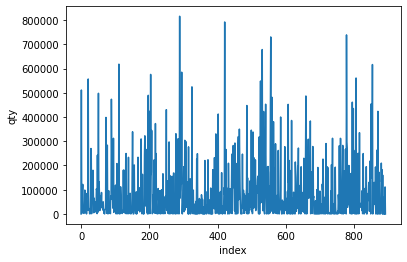

In [377]:
sns.lineplot(x = 'index', y  ='qty', data = plt1)

---

In [ ]:
train_first.pop('CREATION_DATE_TIME_STAMP')
train_full.pop('CREATION_DATE_TIME_STAMP')

In [316]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn import model_selection
cv_split = model_selection.ShuffleSplit(
    n_splits = 6, 
    test_size = .25, 
    train_size = .75, 
    random_state = 1026529)
alg1 = Lasso()

cv_results_1 = model_selection.cross_validate(
    alg1, 
    train_first, train_full['qty'], 
    cv  = cv_split, scoring='neg_mean_absolute_percentage_error')


cv_results_1['test_score'].mean()

-338.4306458010412

In [338]:
from sklearn.ensemble import RandomForestRegressor
alg2 = RandomForestRegressor(n_estimators = 34, 
        max_depth = 61,
        min_samples_split = 3, 
        min_samples_leaf=4, 
        # max_leaf_nodes = 31
        )
cv_results_2 = model_selection.cross_validate(
        alg2, 
        train_first, 
        train_full['qty'], 
        cv  = cv_split, scoring='neg_mean_absolute_percentage_error')
cv_results_2['test_score'].mean()

-232.76419329714838

In [330]:
alg2.fit(train_first,train_full['qty']).predict(train_first)

array([ 46535.93848039, 266403.40217087,  19529.51666667,  62376.25070028,
        75254.13444742, 111546.50318627,  68106.13504902, 138158.88711485,
        45976.27696078,  70012.99635854,  63572.22521008, 156882.70714286,
        57377.74453782,  66635.18651961,  73667.00910364,  86934.0877451 ,
       127749.24509804,  45824.52941176, 151389.71057423,  52619.3219888 ,
        38503.26713352, 274795.87605042, 105436.59481793,  72376.25637255,
        26494.13011204,  24766.71372549,  28538.93872549,  35923.18979501,
        39476.05686275, 122834.45336134, 101688.1464986 ,  80060.19093137,
       139255.12706583,  57453.8075121 ,  93360.09068627, 176030.04488796,
       152534.85406162,  42788.32303922, 147817.29509804,  48381.53104575,
        46951.12303922, 123375.55014006,  41718.5912656 ,  80455.64803922,
        43620.54789916, 124502.65751634, 121356.54576331,  30447.95178571,
       272968.68172269,  63672.91435574,  97555.68809524, 320435.14289216,
       120045.56827731, 1

In [344]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (891, 891, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'identity', 
    solver = 'adam', learning_rate = 'adaptive')
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()

Iteration 1, loss = 9840332447.91429901
Iteration 2, loss = 9823633812.44610023
Iteration 3, loss = 9285683588.69616127
Iteration 4, loss = 9129133414.94727898
Iteration 5, loss = 9087299891.99265099
Iteration 6, loss = 9007139735.40104866
Iteration 7, loss = 8958141045.89183617
Iteration 8, loss = 9174486371.70582771
Iteration 9, loss = 8999906673.59621048
Iteration 10, loss = 9008252087.24812508
Iteration 11, loss = 9135441568.93227386
Iteration 12, loss = 9023088745.45179367
Iteration 13, loss = 9055065348.78659058
Iteration 14, loss = 9008845034.70876312
Iteration 15, loss = 9011032980.04362488
Iteration 16, loss = 9028369498.72106552
Iteration 17, loss = 8994303248.62904358
Iteration 18, loss = 9134571263.38923264
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 11436659028.09517670
Iteration 2, loss = 11498963090.90554428
Iteration 3, loss = 10332312066.27833366
Iteration 4, loss = 10247012589.37348747
Iteration 5, loss

-123.86910109178324

In [347]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (1120, 850, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'relu', 
    solver = 'adam', 
    learning_rate = 'adaptive',
    warm_start = True,
    early_stopping = True
    )
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()

Iteration 1, loss = 11462717042.93061256
Validation score: -0.545942
Iteration 2, loss = 10474969752.80696106
Validation score: -0.979483
Iteration 3, loss = 10201776302.60164261
Validation score: -0.483464
Iteration 4, loss = 9848932678.67110825
Validation score: -0.499403
Iteration 5, loss = 10556054171.12208748
Validation score: -0.561567
Iteration 6, loss = 10807036677.99097633
Validation score: -0.548124
Iteration 7, loss = 10648495341.05313301
Validation score: -0.480177
Iteration 8, loss = 10189507009.83472633
Validation score: -0.427528
Iteration 9, loss = 9674814488.44912338
Validation score: -0.681424
Iteration 10, loss = 10125834983.31689453
Validation score: -1.070531
Iteration 11, loss = 10299989791.72861671
Validation score: -0.655199
Iteration 12, loss = 9433427306.25110817
Validation score: -0.486642
Iteration 13, loss = 9584059852.33731461
Validation score: -0.495589
Iteration 14, loss = 9752590158.92021942
Validation score: -0.497153
Iteration 15, loss = 9676567073.88

-186.27219196212357